# Problem Statement: Song Recommendation Model based on Sound Features & Genres

### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

### Reading the cleaned dataset

In [2]:
cleaned_tracks = pd.read_csv('cleaned_dataset.csv')

### Clustering Songs based on sound features using KMeans

In [3]:
variables= {
    "sound_features": ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],

}

results = []

for name, variable in variables.items():
    X = cleaned_tracks[variable].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)


    kmeans = KMeans(n_clusters=7, random_state=20)
    clusters = kmeans.fit_predict(X_scaled)


    cleaned_tracks.loc[:, "cluster"] = clusters #to prevent the SettingwithCopyWarning

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, clusters, test_size=0.25, random_state=20)

    # Decision tree
    dectree = DecisionTreeClassifier(max_depth=5)
    dectree.fit(X_train, y_train)

    test_accuracy = dectree.score(X_test, y_test)
    results.append((name, test_accuracy))

for variable_name, acc in results:
    print(f"variable: {variable_name}, Test Accuracy: {acc:.4f}")



variable: sound_features, Test Accuracy: 0.8224


From the results, we see sound features have a high accuracy, which makes sense since listeners want to hear songs that sound similar in terms of the musicality. Although the train-test split here doesn't test predictive power since we're using unsupervised clustering labels, it serves as a validation step to show that the clustering done by KMeans is consistent enough for a decision tree to learn and generalize.


# Clustering songs based on sound features

First we need to get the optimal number of clusters using the Elbow Method


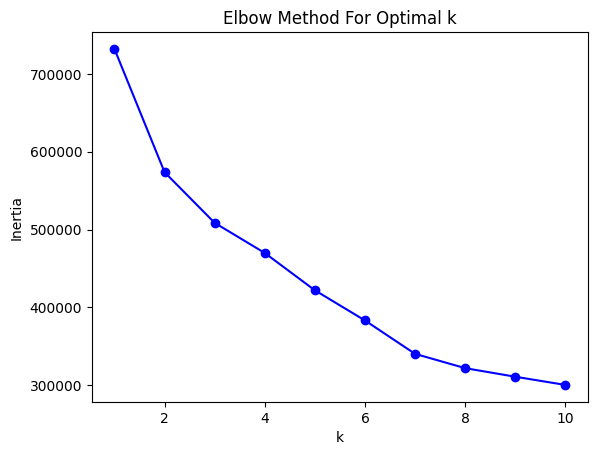

In [4]:
features = ['danceability', 'energy', 'valence', 'tempo',
            'acousticness', 'instrumentalness', 'liveness',
            'loudness', 'speechiness']

X = cleaned_tracks[features].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [5]:
# Optimal number of clusters found
k = 7

# Start clustering
kmeans = KMeans(n_clusters=k, random_state=42)
cleaned_tracks.loc[X.index, 'cluster'] = kmeans.fit_predict(X_scaled)

print(cleaned_tracks[['track_name', 'artists', 'cluster'] + features].sample(10))

                   track_name                            artists  cluster  \
66262           Bleeding Love                      The Baseballs        1   
1007           Povo Guerreiro                             Criolo        0   
46937          Tell Him a Lie                        Vybz Kartel        1   
64488               Escuchame                        Fidel Rueda        0   
65529     Cuando Sali De Cuba                         Mike Laure        0   
28987           Por um Minuto                Chicão dos Teclados        0   
28810     Se Mancol - Ao Vivo               Companhia do Calypso        0   
32868  Vitorioso És - ao vivo                       Gabi Sampaio        3   
349      Can't Keep It Inside  Brett Dennen;Benedict Cumberbatch        1   
30921             Hey Wanhaka                      King Stingray        3   

       danceability  energy  valence    tempo  acousticness  instrumentalness  \
66262         0.403  0.6000    0.832   78.084        0.5960          0.

Now that we have clustered the songs, we can look into the details of each cluster

cluster
0    23975
1    16146
2     9736
3    18405
4     5797
5     1023
6     6262
dtype: int64
         danceability  energy  valence   tempo  acousticness  \
cluster                                                        
0                0.70    0.71     0.70  118.76          0.23   
1                0.53    0.38     0.39  113.42          0.68   
2                0.58    0.74     0.34  127.01          0.11   
3                0.47    0.82     0.37  139.26          0.07   
4                0.52    0.75     0.50  123.15          0.30   
5                0.57    0.68     0.44  100.51          0.75   
6                0.34    0.17     0.17  102.31          0.86   

         instrumentalness  liveness  loudness  speechiness  
cluster                                                     
0                    0.02      0.17     -6.64         0.10  
1                    0.04      0.16    -10.67         0.05  
2                    0.80      0.17     -8.48         0.07  
3                   

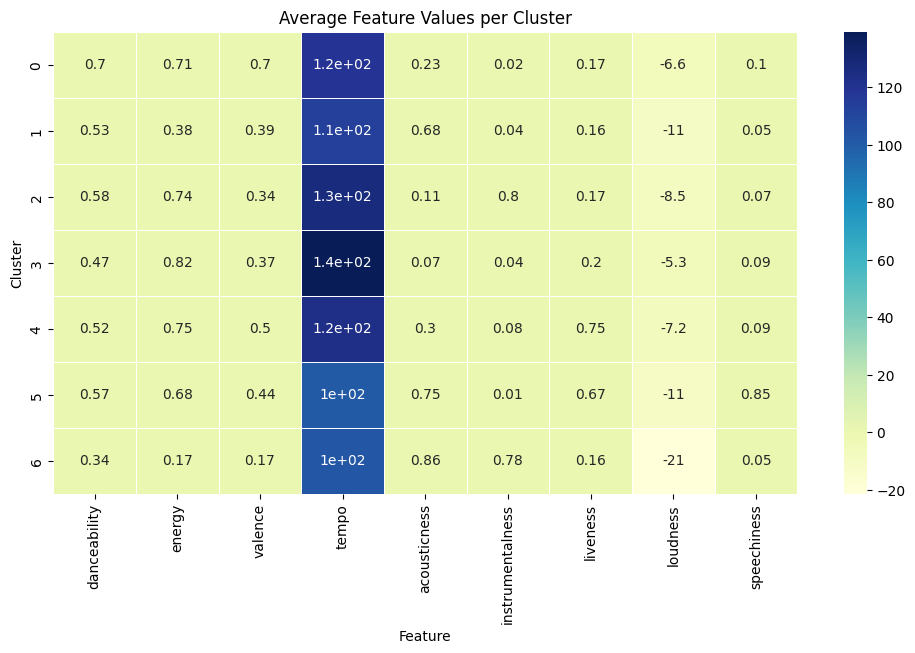

In [6]:
# Group songs by respective clusters and calculate the mean of each sound feature
cluster_summary = cleaned_tracks.groupby('cluster')[features].mean().round(2)

cluster_counts = cleaned_tracks.groupby('cluster').size()
print(cluster_counts)
print(cluster_summary)
print()


plt.figure(figsize=(12, 6))
sb.heatmap(cluster_summary, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Average Feature Values per Cluster")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.show()

Visualising the clusters with PCA

In [7]:
def pca_songs(cleaned_tracks, features):
    pca = PCA(n_components=2)
    components = pca.fit_transform(cleaned_tracks[features])

    # Add PCA components to DataFrame
    cleaned_tracks.loc[:, 'pca_x'] = components[:, 0]
    cleaned_tracks.loc[:, 'pca_y'] = components[:, 1]

    # Create hover labels
    hover_text = cleaned_tracks['track_name'] + " by " + cleaned_tracks['artists']

    # Create interactive plot
    fig = px.scatter(
        cleaned_tracks,
        x='pca_x',
        y='pca_y',
        color='cluster',
        hover_name=hover_text,
        title='Interactive PCA Visualization of Song Clusters',
        labels={'pca_x': 'PCA Component 1', 'pca_y': 'PCA Component 2'},
        color_continuous_scale='Viridis' if cleaned_tracks['cluster'].dtype != 'object' else None
    )

    fig.update_layout(
        legend_title_text='Cluster',
        width=900,
        height=600
    )

    fig.show()

pca_songs(cleaned_tracks, features)

# Building the Recommendation Model

In [8]:
def recommend_songs(song_name, cleaned_tracks, features, n=5):
    target_song = cleaned_tracks[cleaned_tracks['track_name'].str.lower() == song_name.lower()]
    if target_song.empty:
        return "Song not found."

    # find cluster which the input song most likely belongs to
    target_cluster = target_song['cluster'].values[0]

    # filter to make sure songs other than input song is recommended
    same_cluster = cleaned_tracks[
        (cleaned_tracks['cluster'] == target_cluster) &
        (cleaned_tracks['track_name'].str.lower() != song_name.lower())
    ]

    if same_cluster.empty:
        return "No other songs found in the same cluster."

    # find euclidean distance for songs in the cluster
    target_vector = target_song[features].values
    cluster_vectors = same_cluster[features].values
    distances = cdist(target_vector, cluster_vectors, metric='euclidean')[0]

    same_cluster = same_cluster.copy()
    same_cluster['distance'] = distances
    same_cluster = same_cluster.sort_values('distance')

    # return closest songs in the same cluster
    recommendations = same_cluster.sort_values('distance').head(n)
    return recommendations[['track_name', 'artists', 'distance', 'cluster']]




In [9]:
print(recommend_songs("You Might Think He Loves You for Your Money but I Know What He Really Loves You for It's Your Brand New Leopard Skin Pillbox Hat", cleaned_tracks, features))


                       track_name               artists  distance  cluster
35165                    Pathetic           Lamb of God  0.400273        3
54541                  Hypermania               Polaris  0.411258        3
38876              Kami Masih Ada       Straight Answer  0.488449        3
61754  They Came from the Shadows  Teenage Bottlerocket  0.532356        3
38839                 Give It All          Rise Against  0.635150        3


# Evaluation
We made a recommendation model based on how similar other songs are to the sound features of the input song using K Means. However, we acknowledge the limitations of our code - that it is limited to the dataset, which can be expanded to even take in the user's spotify ID and cater to their own playlists. Furthermore, our recommendation model does not account for user preferences like lyrics or genre types.